In [1]:
from IPython.display import Image, HTML

<h1 style="text-align:center"> ASETools database module </h1>

# DB schema

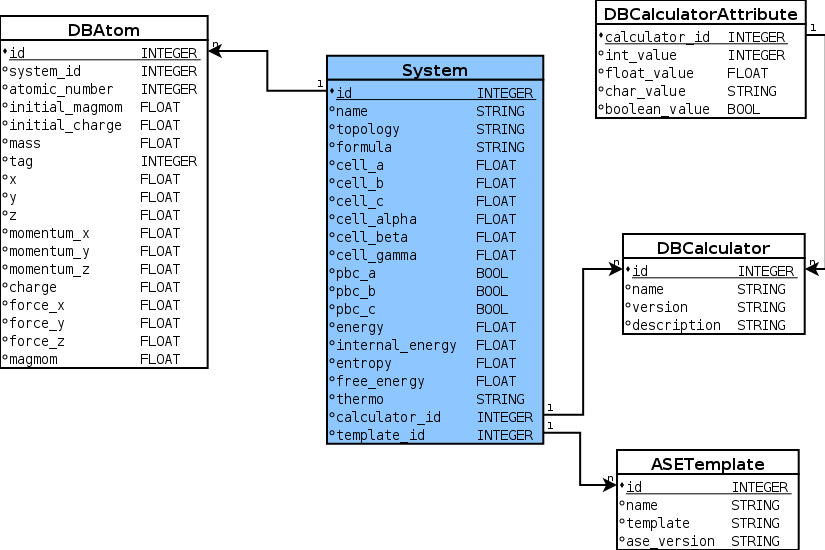

In [2]:
Image(filename='../docs/source/img/db.png') 

# where is it ?

In [3]:
!tree /home/lmentel/Devel/asetools/asetools

/home/lmentel/Devel/asetools/asetools
├── asetools.py
├── asetools.pyc
├── db
│   ├── dbinterface.py
│   ├── __init__.py
│   ├── __init__.pyc
│   ├── model.py
│   └── model.pyc
├── __init__.py
├── __init__.pyc
├── submit.py
├── submit.pyc
└── templates
    ├── ads_energy_Ge_template.py
    ├── ads_energy_template.py
    ├── BEEFzeoliteonly_template.py
    ├── clusterScreenDPE_template.py
    ├── clusterScreenNH3ads_template.py
    ├── dos_template_espresso.py
    ├── dos_template_gpaw.py
    ├── gencube_template.py
    ├── GPAW_DPE_template.py
    ├── IR_template_gpaw.py
    ├── jmol_template
    ├── molecule_template.py
    ├── ph_template.py
    ├── pp_template.py
    ├── preparefreq_hydrocarbon_template.py
    ├── QEase_template.py
    ├── QEase_vibHarm_template.py
    ├── QEase_vibIdeal_template.py
    ├── QEase_vib_template.py
    ├── QE_DPE_template.py
    ├── QEnative_template.py
    ├── vac_conv_template.py
    ├── ZSM22_addmolecule_template.py
    └── ZSM22_BEEFporemouthads_te

In [ ]:
# %load /home/lmentel/Devel/asetools/asetools/db/model.py

''' a database for storing the ase atoms abjects'''

from __future__ import unicode_literals, print_function, division

from sqlalchemy import (Column, LargeBinary, Integer, String, Float,
        PickleType, ForeignKey, DateTime, Unicode, UnicodeText, Boolean)
from sqlalchemy.orm import relationship
from sqlalchemy.orm.collections import attribute_mapped_collection
from sqlalchemy.ext.associationproxy import association_proxy
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.ext.hybrid import hybrid_property
import os
from operator import attrgetter
import datetime

# code  below is taken from:
# http://docs.sqlalchemy.org/en/latest/_modules/examples/vertical/dictlike-polymorphic.html

from sqlalchemy.orm.interfaces import PropComparator
from sqlalchemy import event, cast, case, null, literal_column

class ProxiedDictMixin(object):
    """Adds obj[key] access to a mapped class.

    This class basically proxies dictionary access to an attribute
    called ``_proxied``.  The class which inherits this class
    should have an attribute called ``_proxied`` which points to a dictionary.
    """

    def __len__(self):
        return len(self._proxied)

    def __iter__(self):
        return iter(self._proxied)

    def __getitem__(self, key):
        return self._proxied[key]

    def __contains__(self, key):
        return key in self._proxied

    def __setitem__(self, key, value):
        self._proxied[key] = value

    def __delitem__(self, key):
        del self._proxied[key]

class PolymorphicVerticalProperty(object):
    """A key/value pair with polymorphic value storage.

    The class which is mapped should indicate typing information
    within the "info" dictionary of mapped Column objects; see
    the AnimalFact mapping below for an example.

    """

    def __init__(self, key, value=None):
        self.key = key
        self.value = value

    @hybrid_property
    def value(self):
        fieldname, discriminator = self.type_map[self.type]
        if fieldname is None:
            return None
        else:
            return getattr(self, fieldname)

    @value.setter
    def value(self, value):
        py_type = type(value)
        fieldname, discriminator = self.type_map[py_type]

        self.type = discriminator
        if fieldname is not None:
            setattr(self, fieldname, value)

    @value.deleter
    def value(self):
        self._set_value(None)

    @value.comparator
    class value(PropComparator):
        """A comparator for .value, builds a polymorphic comparison via CASE.

        """
        def __init__(self, cls):
            self.cls = cls

        def _case(self):
            pairs = set(self.cls.type_map.values())
            whens = [
                (
                    literal_column("'%s'" % discriminator),
                    cast(getattr(self.cls, attribute), String)
                ) for attribute, discriminator in pairs
                if attribute is not None
            ]
            return case(whens, self.cls.type, null())
        def __eq__(self, other):
            return self._case() == cast(other, String)
        def __ne__(self, other):
            return self._case() != cast(other, String)

    def __repr__(self):
        return '<%s %r=%r>' % (self.__class__.__name__, self.key, self.value)

@event.listens_for(PolymorphicVerticalProperty, "mapper_configured", propagate=True)
def on_new_class(mapper, cls_):
    """Look for Column objects with type info in them, and work up
    a lookup table."""

    info_dict = {}
    info_dict[type(None)] = (None, 'none')
    info_dict['none'] = (None, 'none')

    for k in mapper.c.keys():
        col = mapper.c[k]
        if 'type' in col.info:
            python_type, discriminator = col.info['type']
            info_dict[python_type] = (k, discriminator)
            info_dict[discriminator] = (k, discriminator)
    cls_.type_map = info_dict

# end of the borrowed code

Base = declarative_base()

class DBCalculatorAttribute(PolymorphicVerticalProperty, Base):
    '''class to handle storing key-value pairs for the calculator attributes'''

    __tablename__ = 'calculator_attributes'

    calculator_id = Column(ForeignKey('calculators.id'), primary_key=True)
    key = Column(Unicode(64), primary_key=True)
    type = Column(Unicode(16))

    # add information about storage for different types
    # in the info dictionary of Columns
    int_value = Column(Integer, info={'type': (int, 'integer')})
    float_value = Column(Float, info={'type': (float, 'float')})
    char_value = Column(UnicodeText, info={'type': (str, 'string')})
    boolean_value = Column(Boolean, info={'type': (bool, 'boolean')})

class DBCalculator(ProxiedDictMixin, Base):

    __tablename__ = 'calculators'

    id = Column(Integer, primary_key=True)
    name = Column(String)
    version = Column(String)
    description = Column(String)

    attributes = relationship("DBCalculatorAttribute",
                    collection_class=attribute_mapped_collection('key'))
    _proxied = association_proxy("attributes", "value",
                        creator=
                        lambda key, value: DBCalculatorAttribute(key=key, value=value))

    @classmethod
    def with_attr(self, key, value):
        return self.attributes.any(key=key, value=value)

    def __repr__(self):

        out = ["DBCalculator(id={0}, name='{1:s}', version={2:s}, description={3:s},".format(
                self.id, self.name, self.version, self.description)]
        out.extend(["\t{0:s} = {1}".format(k, v) for k, v in self.attributes.items()])

        return "\n".join(out) + ')'

class ASETemplateNote(PolymorphicVerticalProperty, Base):
    '''class to handle storing key-value pairs for the calculator attributes'''

    __tablename__ = 'asetemplate_notes'

    template_id = Column(ForeignKey('asetemplates.id'), primary_key=True)
    key = Column(Unicode(64), primary_key=True)
    type = Column(Unicode(16))

    # add information about storage for different types
    # in the info dictionary of Columns
    int_value = Column(Integer, info={'type': (int, 'integer')})
    float_value = Column(Float, info={'type': (float, 'float')})
    char_value = Column(UnicodeText, info={'type': (str, 'string')})
    boolean_value = Column(Boolean, info={'type': (bool, 'boolean')})

class ASETemplate(ProxiedDictMixin, Base):

    __tablename__ = 'asetemplates'

    id = Column(Integer, primary_key=True)
    name = Column(String)
    template = Column(String)
    ase_version = Column(String)

    notes = relationship('ASETemplateNote',
                collection_class=attribute_mapped_collection('key'))

    _proxied = association_proxy('notes', 'value',
                        creator=
                        lambda key, value: ASETemplateNote(key=key, value=value))

    @classmethod
    def with_note(self, key, value):
        return self.notes.any(key=key, value=value)

    def __repr__(self):

        out = ["ASETemplate(id={0}, name='{1:s}', ase_version={2:s},".format(
                self.id, self.name, self.ase_version)]
        out.extend(["\t{0:s} = {1}".format(k, v) for k, v in self.notes.items()])

        return "\n".join(out) + ')'

class DBAtom(Base):
    '''Atom ORM object'''

    __tablename__ = 'atoms'

    id = Column(Integer, primary_key=True)
    system_id = Column(Integer, ForeignKey('systems.id'))

    atomic_number = Column(Integer)
    initial_magmom = Column(Float)
    initial_charge = Column(Float)
    mass = Column(Float)
    tag = Column(Integer)

    x = Column(Float)
    y = Column(Float)
    z = Column(Float)

    momentum_x = Column(Float)
    momentum_y = Column(Float)
    momentum_z = Column(Float)

    charge = Column(Float)
    force_x = Column(Float)
    force_y = Column(Float)
    force_z = Column(Float)
    magmom = Column(Float)

class SystemNote(PolymorphicVerticalProperty, Base):
    '''class to handle storing key-value pairs for the system'''

    __tablename__ = 'system_notes'

    system_id = Column(ForeignKey('systems.id'), primary_key=True)
    key = Column(Unicode(64), primary_key=True)
    type = Column(Unicode(16))

    # add information about storage for different types
    # in the info dictionary of Columns
    int_value = Column(Integer, info={'type': (int, 'integer')})
    float_value = Column(Float, info={'type': (float, 'float')})
    char_value = Column(UnicodeText, info={'type': (str, 'string')})
    boolean_value = Column(Boolean, info={'type': (bool, 'boolean')})

class System(ProxiedDictMixin, Base):
    '''
    System ORM object

    Attributes:
      username : str
        Name of the user
      name : str
        Name of the system
      topology : str
        Three letter code of the zeolite framework topology
      formula : str
        Chemical formula of the system (unit cell)
    '''

    __tablename__ = 'systems'

    id = Column(Integer, primary_key=True)

    ctime = Column(DateTime, default=datetime.datetime.now)
    mtime = Column(DateTime, default=datetime.datetime.now, onupdate=datetime.datetime.now)
    username = Column(String)

    name = Column(String)
    topology = Column(String(3))
    formula = Column(String)

    cell_a = Column(Float)
    cell_b = Column(Float)
    cell_c = Column(Float)
    cell_alpha = Column(Float)
    cell_beta = Column(Float)
    cell_gamma = Column(Float)
    pbc_a = Column(Boolean)
    pbc_b = Column(Boolean)
    pbc_c = Column(Boolean)

    # results of the calculation

    energy = Column(Float)
    internal_energy = Column(Float)
    entropy = Column(Float)
    free_energy = Column(Float)
    thermo = Column(String)
    #magmom = Column(Float)
    #dipole_x = Column(Float)
    #dipole_y = Column(Float)
    #dipole_z = Column(Float)
    #stress = Column(PickleType)

    atoms = relationship('DBAtom')

    calculator_id = Column(ForeignKey('calculators.id'))
    calculator = relationship('DBCalculator')

    template_id = Column(ForeignKey('asetemplates.id'))
    template = relationship('ASETemplate')

    notes = relationship('SystemNote',
                collection_class=attribute_mapped_collection('key'))

    _proxied = association_proxy('notes', 'value',
                        creator=
                        lambda key, value: SystemNote(key=key, value=value))

#    def __init__(self, name):
#        self.name = name

    def __repr__(self):
        return "<System(name={0:s}, topology={1:s})>".format(self.name, self.topology)

    @classmethod
    def with_note(self, key, value):
        return self.notes.any(key=key, value=value)

    def __repr__(self):

        out = ["System(id={0}, name='{1:s}', topology={2:s}, formula={3:s},".format(
                self.id, self.name, self.topology, self.formula)]
        out.extend(["\t{0:s} = {1}".format(k, v) for k, v in self.notes.items()])

        return "\n".join(out) + ')'



# SQLAlchemy and Object-Relational Mapping (ORM)

Translation of **ASE** python objects to database ompatible objects

* Atoms -> DBAtom (System), *atoms2systems*
* Calculator -> DBCalculator, *calculator2db*
* ASETemplate

In [4]:
HTML('<iframe src=http://docs.sqlalchemy.org/en/rel_1_0/orm/tutorial.html width=900 height=400></iframe>')

In [5]:
from sqlalchemy import and_, or_
from asetools.db import (get_session, DBAtom, System, SystemNote, atoms2system, get_atoms,
                         DBCalculator, calculator2db, ASETemplate)

# Create the database and get connection

In [6]:
%ls -l

razem 4412
-rw-r--r-- 1 lmentel lmentel    1530 paź 21 10:20 AFI.cif
-rw-r--r-- 1 lmentel lmentel   17296 paź 20 22:18 applications_and_workflow_automation.ipynb
-rw-r--r-- 1 lmentel lmentel     265 paź 20 17:48 co.xyz
-rw-r--r-- 1 lmentel lmentel  719824 paź 21 10:41 db-intro.ipynb
-rw-r--r-- 1 lmentel lmentel  146144 paź 21 11:17 db-tutorial.ipynb
-rw-r--r-- 1 lmentel lmentel 3206144 paź 20 17:34 mytest.db
-rw-r--r-- 1 lmentel lmentel  411361 paź 20 14:20 RDBinchemistry.png


In [7]:
dbpath = 'mytest.db'

## Connect to the basis set and get the session object

In [8]:
session = get_session(dbpath)

# Querying

* filter
* all
* one
* first
* order_by
* count
* get

In [9]:
session.query(System).first()

System(id=1, name='N(IV)-AlPO-5-H', topology=AFI, formula=HAl24NO96P23,
	relaxed = <SystemNote u'relaxed'=True>)

In [10]:
s = session.query(System).first()

In [11]:
s.name

u'N(IV)-AlPO-5-H'

In [12]:
s.formula

u'HAl24NO96P23'

In [13]:
s.energy

-51688.9584788133

In [15]:
len(s.atoms)

145

## filter

In [16]:
session.query(System).filter(System.name.like('%-NH3%')).count()

82

In [18]:
session.query(System).filter(System.energy > -1000.0).all()

[System(id=167, name='ammonia', topology=None, formula=H3N,
 	relaxed = <SystemNote u'relaxed'=True>),
 System(id=250, name='Carbon monoxide', topology=None, formula=CO,)]

In [19]:
session.query(System).filter(System.energy > -1000.0).all()

[System(id=167, name='ammonia', topology=None, formula=H3N,
 	relaxed = <SystemNote u'relaxed'=True>),
 System(id=250, name='Carbon monoxide', topology=None, formula=CO,)]

In [20]:
q = (session.query(System).
         filter(System.notes.any(
           and_(SystemNote.key == 'relaxed',
                SystemNote.value == True))))

In [21]:
q.count()

/usr/local/lib/python2.7/dist-packages/sqlalchemy/sql/sqltypes.py:185: SAWarning: Unicode type received non-unicode bind param value 'relaxed'. (this warning may be suppressed after 10 occurrences)
  (util.ellipses_string(value),))


249

In [22]:
session.query(DBCalculator).all()

[DBCalculator(id=1, name='QE-ASE3 interface', version=0.1, description=calculator used for geometry relaxation,
 	kpts = <DBCalculatorAttribute u'kpts'=u'gamma'>
 	pw = <DBCalculatorAttribute u'pw'=600>
 	calcmode = <DBCalculatorAttribute u'calcmode'=u'scf'>
 	xc = <DBCalculatorAttribute u'xc'=u'BEEF-vdW'>
 	convergence = <DBCalculatorAttribute u'convergence'=u'{"energy": 1e-10}'>
 	dw = <DBCalculatorAttribute u'dw'=7000>
 	sigma = <DBCalculatorAttribute u'sigma'=0.1>
 	spinpol = <DBCalculatorAttribute u'spinpol'=False>)]

In [23]:
session.query(ASETemplate).all()

[ASETemplate(id=1, name='geometry relaxation', ase_version=3.9.1.4567,),
 ASETemplate(id=2, name='geometry and cell relaxation', ase_version=3.9.1.4567,),
 ASETemplate(id=3, name='single point crystal energy calculation', ase_version=3.9.1.4567,),
 ASETemplate(id=4, name='single point molecule energy calculation', ase_version=3.9.1.4567,),
 ASETemplate(id=5, name='geometry relaxation and ideal gas thermo', ase_version=3.9.1.4567,),
 ASETemplate(id=6, name='pw convergence scan', ase_version=3.9.1.4567,)]

## get Mg(II) AlPO-5-H and view the atoms 

In [24]:
MgAlPO5H = session.query(System).filter(System.name.like('Mg%-H')).one()

In [25]:
atoms = get_atoms(session, MgAlPO5H.id)

/home/lmentel/.virtualenvs/cat/local/lib/python2.7/site-packages/ase/atoms.py:529: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if masses == 'defaults':


In [26]:
from ase.visualize import view

In [27]:
view(atoms)

# Adding stuff

# Calculator 

- name
- version
- description
- attributes

In [28]:
from espresso import espresso

In [29]:
qec = espresso(pw=600,
                dw=7000,
                xc = "BEEF-vdW",
                sigma = 0.1,
                convergence={'energy':1e-10},
                spinpol=False,
                mode='scf', #single-point energy calculation per displacement
                onlycreatepwinp=True
                )

In [30]:
dbc = calculator2db(qec, attrs='basic', description='dummy calculator')

In [31]:
session.add(dbc)

In [32]:
session.commit()

/usr/local/lib/python2.7/dist-packages/sqlalchemy/sql/sqltypes.py:185: SAWarning: Unicode type received non-unicode bind param value 'kpts'. (this warning may be suppressed after 10 occurrences)
  (util.ellipses_string(value),))
/usr/local/lib/python2.7/dist-packages/sqlalchemy/sql/sqltypes.py:185: SAWarning: Unicode type received non-unicode bind param value 'string'. (this warning may be suppressed after 10 occurrences)
  (util.ellipses_string(value),))
/usr/local/lib/python2.7/dist-packages/sqlalchemy/sql/sqltypes.py:185: SAWarning: Unicode type received non-unicode bind param value '[1, 1, 1]'. (this warning may be suppressed after 10 occurrences)
  (util.ellipses_string(value),))
/usr/local/lib/python2.7/dist-packages/sqlalchemy/sql/sqltypes.py:185: SAWarning: Unicode type received non-unicode bind param value 'pw'. (this warning may be suppressed after 10 occurrences)
  (util.ellipses_string(value),))
/usr/local/lib/python2.7/dist-packages/sqlalchemy/sql/sqltypes.py:185: SAWarnin

In [33]:
session.query(DBCalculator).all()

[DBCalculator(id=1, name='QE-ASE3 interface', version=0.1, description=calculator used for geometry relaxation,
 	kpts = <DBCalculatorAttribute u'kpts'=u'gamma'>
 	pw = <DBCalculatorAttribute u'pw'=600>
 	calcmode = <DBCalculatorAttribute u'calcmode'=u'scf'>
 	xc = <DBCalculatorAttribute u'xc'=u'BEEF-vdW'>
 	convergence = <DBCalculatorAttribute u'convergence'=u'{"energy": 1e-10}'>
 	dw = <DBCalculatorAttribute u'dw'=7000>
 	sigma = <DBCalculatorAttribute u'sigma'=0.1>
 	spinpol = <DBCalculatorAttribute u'spinpol'=False>),
 DBCalculator(id=2, name='QE-ASE3 interface', version=0.1, description=dummy calculator,
 	kpts = <DBCalculatorAttribute u'kpts'=u'[1, 1, 1]'>
 	pw = <DBCalculatorAttribute u'pw'=600>
 	calcmode = <DBCalculatorAttribute u'calcmode'=u'scf'>
 	xc = <DBCalculatorAttribute u'xc'=u'BEEF-vdW'>
 	convergence = <DBCalculatorAttribute u'convergence'=u'{"energy": 1e-10}'>
 	dw = <DBCalculatorAttribute u'dw'=7000>
 	sigma = <DBCalculatorAttribute u'sigma'=0.1>
 	spinpol = <DBCal

# Template

In [36]:
dummy = '''

can contain code

dummy template

'''

In [37]:
import ase.version

In [38]:
at = ASETemplate(name='dummy template', template=dummy, ase_version=ase.version.version)

In [39]:
session.add(at)

In [40]:
session.commit()

In [41]:
session.query(ASETemplate).all()

[ASETemplate(id=1, name='geometry relaxation', ase_version=3.9.1.4567,),
 ASETemplate(id=2, name='geometry and cell relaxation', ase_version=3.9.1.4567,),
 ASETemplate(id=3, name='single point crystal energy calculation', ase_version=3.9.1.4567,),
 ASETemplate(id=4, name='single point molecule energy calculation', ase_version=3.9.1.4567,),
 ASETemplate(id=5, name='geometry relaxation and ideal gas thermo', ase_version=3.9.1.4567,),
 ASETemplate(id=6, name='pw convergence scan', ase_version=3.9.1.4567,),
 ASETemplate(id=7, name='dummy template', ase_version=3.9.1.4567,)]

# Atoms

### water molecule

In [42]:
from ase import Atoms

In [43]:
h2o = Atoms('HHO', positions=((0.758602, 0.000000, 0.504284),
                              (0.758602, 0.000000, -0.504284),
                              (0.000000, 0.000000, 0.000000)))

In [44]:
view(h2o)

## convert atoms to a mapped object

In [45]:
dbh2o = atoms2system(atoms=h2o, username='lmentel', name='water molecule', topology=None,
                     notes={'geometry' : 'initial', 'relaxed' : False})

In [46]:
session.add(dbh2o)

In [47]:
session.commit()

/usr/local/lib/python2.7/dist-packages/sqlalchemy/sql/sqltypes.py:185: SAWarning: Unicode type received non-unicode bind param value 'initial'. (this warning may be suppressed after 10 occurrences)
  (util.ellipses_string(value),))


In [61]:
session.query(System).filter(System.name == 'water molecule').one()

NoResultFound: No row was found for one()

# Update

In [49]:
h2o = session.query(System).filter(System.name == 'water molecule').one()

# attach calcualtor and template (via relation to object we defined)

In [50]:
dbtemp = session.query(ASETemplate).filter(ASETemplate.name == 'dummy template').one()

In [51]:
calc = session.query(DBCalculator).filter(DBCalculator.description == 'dummy calculator').one()

In [52]:
h2o.template = dbtemp

In [53]:
h2o.calculator = calc

In [54]:
session.add(h2o)

In [55]:
session.commit()

In [56]:
newh2o = session.query(System).filter(System.name.like('water%')).one()

In [57]:
newh2o.ca

DBCalculator(id=2, name='QE-ASE3 interface', version=0.1, description=dummy calculator,
	kpts = <DBCalculatorAttribute u'kpts'=u'[1, 1, 1]'>
	pw = <DBCalculatorAttribute u'pw'=600>
	calcmode = <DBCalculatorAttribute u'calcmode'=u'scf'>
	xc = <DBCalculatorAttribute u'xc'=u'BEEF-vdW'>
	convergence = <DBCalculatorAttribute u'convergence'=u'{"energy": 1e-10}'>
	dw = <DBCalculatorAttribute u'dw'=7000>
	sigma = <DBCalculatorAttribute u'sigma'=0.1>
	spinpol = <DBCalculatorAttribute u'spinpol'=False>)

In [58]:
newh2o.template

ASETemplate(id=7, name='dummy template', ase_version=3.9.1.4567,)

# Delete

In [59]:
session.delete(newh2o)
session.delete(calc)
session.delete(dbtemp)

In [60]:
session.commit()

# Finalize

In [62]:
session.close()

# CLI for adding trajectory files

dbadd 

In [63]:
!dbadd -h

usage: dbadd [-h] [-n NAME] [-t TOPOLOGY] [-c CALCID] [-a TEMPID] [--notes NOTES] db traj

positional arguments:
  db                    database file
  traj                  trajectory file

optional arguments:
  -h, --help            show this help message and exit
  -n NAME, --name NAME  name of the system
  -t TOPOLOGY, --topology TOPOLOGY
                        framework topology code
  -c CALCID, --calcid CALCID
                        calculator id
  -a TEMPID, --tempid TEMPID
                        ase template id
  --notes NOTES         additional system info
